In [1]:
!pip install pandas openpyxl
!pip install requests
#!pip install asyncio
!pip install aiohttp
!pip install nest_asyncio
!pip install scikit-learn
!pip install pytorch-nlp
!pip install tensorflow
!pip install tab-transformer-pytorch
!pip install hyper-connections
!pip install torchsummary


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
import pandas as pd
import requests
from io import BytesIO
import asyncio
import aiohttp
import nest_asyncio  # Allows running asyncio in Jupyter

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

from tab_transformer_pytorch import TabTransformer
from sklearn.metrics import accuracy_score
from torchsummary import summary

In [3]:

nest_asyncio.apply()

async def fetch_url(session,url):

    try:

      async with session.get(url) as response:

        if response.status == 200:
          excel_data = BytesIO(await response.read())
          df = pd.read_excel(excel_data)
          return df
        else:
          raise Exception(f"Failed to retrieve data from {url}. Status code: {response.status}")

    except Exception as e:
      print(f"An error occurred while fetching {url}: {e}")
      return None



async def retrieve_datasets():
    async with aiohttp.ClientSession() as session:

      with open('retention_compounds_url.txt') as file:

        urls = file.readlines()
        urls = [url.strip() for url in urls]
        dfs = []

        tasks = [fetch_url(session,url) for url in urls]

        result = await asyncio.gather(*tasks)

        return result


In [4]:
dfs = asyncio.run(retrieve_datasets())

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

In [5]:
# Model meta data for training later on

NUMERICAL_FEATURES = list(df.select_dtypes(include=['float64','int64']).drop(columns=['RT (min)']).columns.values)
CATEGORICAL_FEATURES_VOCAB = {
    col: sorted(df[col].astype(str).unique().tolist()) for col in df.select_dtypes(include=['object']).columns.values
}

CATEGORICAL_FEATURES = list(CATEGORICAL_FEATURES_VOCAB.keys())

NUM_AND_CAT_FEATURES = NUMERICAL_FEATURES + CATEGORICAL_FEATURES

TARGET_FEATURE = "RT (min)"
#target labels are continuous -100 to 100 idk

# default values for each of the columns, 0 for numerical and N/A for caterogircal. shouldnt be needed since everything is not null alrdy
COLUMN_DEFAULTS = [
    [0.0] if column in NUMERICAL_FEATURES+[TARGET_FEATURE] else ["N/A"]
    for column in NUM_AND_CAT_FEATURES+[TARGET_FEATURE]
]



In [54]:
NUMERICAL_FEATURES

['MCMRT\nNumber', 'Retention Factor (k)', 'RSD']

In [55]:
for i,column in enumerate(df.columns):
    df[column] = df[column].fillna(COLUMN_DEFAULTS[i][0])

print(">>>>>DATAFRAME ONLY WITH NULL filled with N/A",df.isnull().sum())
print(">>>>>Shape: ", df.shape)
df

>>>>>DATAFRAME ONLY WITH NULL filled with N/A MCMRT\nNumber           0
Compound \nName         0
IUPAC \nName            0
Formula                 0
CAS\nNumber             0
Pubchem \nNumber        0
Isomeric SMILES         0
InChI                   0
Retention Factor (k)    0
RT (min)                0
RSD                     0
dtype: int64
>>>>>Shape:  (10073, 11)


,MCMRT\nNumber,Compound \nName,IUPAC \nName,Formula,CAS\nNumber,Pubchem \nNumber,Isomeric SMILES,InChI,Retention Factor (k),RT (min),RSD
0,-1.753352,320,254,49,52,319,249,56,-1.239883,1.31,-0.563829
1,-1.743218,326,336,87,294,311,213,95,-1.238810,1.32,3.090199
2,-1.733083,272,333,71,142,103,261,78,-1.236664,1.35,-0.563829
3,-1.722949,236,316,114,166,133,231,121,-0.928673,5.11,-0.563829
4,-1.712814,341,165,116,58,181,230,122,-1.201250,1.78,0.802163
...,...,...,...,...,...,...,...,...,...,...,...
10068,1.672135,163,177,46,207,238,135,79,0.042517,21.63,-0.222331
10069,1.682270,180,59,95,261,73,337,103,0.091881,22.39,-0.563829
10070,1.692404,184,126,103,91,231,317,109,-0.875016,7.36,-0.222331
10071,1.702539,181,221,104,216,204,182,110,-0.891113,7.10,-0.222331


In [ ]:
#df = final_df.dropna(subset=['CAS\nNumber'], axis=0)

In [ ]:
#print(df.isnull().sum())
#df

In [7]:

# #dummy class for encoding target
# def prepare_example(features, target):
#   return features, target

# # lookup dictionary for categorical features
# lookup_dict = {}

# for feature in CATEGORICAL_FEATURES:
#   vocab = CATEGORICAL_FEATURES_VOCAB[feature] # ie. feature = COMPOUND NAME, vocab = C1, C2, C3, COOH etc
#   lookup = preprocessing.LabelEncoder(vocab)
#   lookup_dict[feature] = lookup # {C1 = 1, C2 = 2, C3 = 4, COOH = 5}


# encodes all the categorical
def encode_categorical(batch_x):

  label_encoder = preprocessing.LabelEncoder()

  for feature in CATEGORICAL_FEATURES:
    batch_x[feature] = batch_x[feature].astype(str)
    batch_x[feature] = label_encoder.fit_transform(batch_x[feature])

  return batch_x

# prepares dataset for training
def get_dataset(df, batch_size=256, shuffle=False):

  df = encode_categorical(df)
  scaler = StandardScaler()

  # preprocess continuous
  scaler.fit(df[NUMERICAL_FEATURES])

  df[NUMERICAL_FEATURES] = scaler.transform(df[NUMERICAL_FEATURES])

  dataset = (
    RetDataset(
      df=df,
      #batch_size = batch_size,
      features = NUM_AND_CAT_FEATURES,
      #column_defaults = COLUMN_DEFAULTS,
      label_name = TARGET_FEATURE,
      #num_epochs = epochs,
      #shuffle= shuffle,
      #lookup_dict = lookup_dict,
    )
  )
  # added 1 to training
  print(f" Dataset: {len(dataset)} Sum of others: {int(0.7*len(dataset))+1+int(0.2*len(dataset))+int(0.1*len(dataset))}")
  train_dataset, test_dataset,val_dataset = random_split(dataset, [int(0.7*len(dataset)+1),int(0.2*len(dataset)),int(0.1*len(dataset))])


  print(f"Dataset Created Successfully! Dataset Size: {dataset.__len__()} Train Size: {train_dataset.__len__()} Test Size: {test_dataset.__len__()} Val Size: {val_dataset.__len__()}")

  return train_dataset,test_dataset,val_dataset




In [8]:
# Defining the dataset


class RetDataset(Dataset):
  def __init__(self, df, features, label_name): # categorical and continuous
    self.data = df
    self.features = features
    self.targets = label_name
    #self.scaler=scaler


  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self,idx):

    continuous_item = self.data.iloc[idx][NUMERICAL_FEATURES].values
    categorical_item = self.data.iloc[idx][CATEGORICAL_FEATURES].values
    target = self.data.iloc[idx][TARGET_FEATURE]

    continuous_item = torch.tensor(continuous_item,dtype=torch.float32)
    categorical_item = torch.tensor(categorical_item,dtype=torch.long)
    target = torch.tensor(target,dtype=torch.float32)

    return continuous_item,categorical_item,target




In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def run_experiment(
    model,
    train_dataset,
    validation_dataset,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
    device=None
):
    # Assign device if not specified
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    print(f">>>>>Using device: {device}")
    model.to(device)  # Move model to device

    # Define optimizer and loss function
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    val_losses_epoch = []
    train_losses_epoch = []
    min_loss = float('inf')


    print("Starting training...")

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        #reset per epoch
        running_loss = 0.0
        running_loss_val = 0.0


        for i, (num, cat, lab) in enumerate(train_loader):
            num, cat, lab = num.to(device), cat.to(device), lab.to(device)

            optimizer.zero_grad()  # Reset gradients

            outputs = model(cat, num)  # Forward pass
            outputs = outputs.squeeze()
            loss = criterion(outputs, lab)  # Compute loss

            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()

            if i % 5 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch {i+1}, Loss: {loss.item():.4f}")

        avg_train_loss = running_loss / len(train_loader)
        print(f">>>>>>>>>>> Epoch [{epoch+1}/{num_epochs}] - Average Training Loss: {avg_train_loss:.4f}")

        train_losses_epoch.append(avg_train_loss)

        # End of Epoch Validation
        # Validation loop
        model.eval()  # Set model to evaluation mode

        with torch.no_grad():

          for num, cat, lab in val_loader:
              num, cat, lab = num.to(device), cat.to(device), lab.to(device)
              outputs = model(cat, num)
              outputs = outputs.squeeze()
              loss = criterion(outputs, lab)  # Compute validation loss
              running_loss_val += loss.item()

        avg_val_loss = running_loss_val / len(val_loader)
        val_losses_epoch.append(avg_val_loss)
        print(f">>>>>>>>>>> Epoch [{epoch+1}/{num_epochs}] validation loss: {avg_val_loss:.4f}")


        if(avg_val_loss < min_loss):
          min_loss = avg_val_loss
          torch.save(model.state_dict(),'best_model.pth')


    return model, val_losses_epoch,train_losses_epoch


In [30]:
lr = 0.001
weight_decay = 0.0001
dropout = 0.2
batch_size = 512
epochs = 25 # change later
num_transformer_blocks = 3
num_heads = 8
embed_dim = 32
mlp_hidden_units = (4,2)
num_mlp_blocks = 2
shuffle=False

In [31]:
train_dataset,test_dataset,val_dataset = get_dataset(df, shuffle=shuffle)

model = TabTransformer(
    categories = tuple(df[CATEGORICAL_FEATURES].nunique().values) ,      # tuple containing the number of unique values within each category
    num_continuous = len(NUMERICAL_FEATURES),                # number of continuous values
    dim = embed_dim,                           # dimension, paper set at 32
    dim_out = 1,                        # binary prediction, but could be anything
    depth = 6,                          # depth, paper recommended 6
    heads = num_heads,                          # heads, paper recommends 8
    attn_dropout = dropout,                 # post-attention dropout
    ff_dropout = dropout,                   # feed forward dropout
    mlp_hidden_mults = mlp_hidden_units,          # relative multiples of each hidden dimension of the last mlp to logits
    mlp_act = nn.ReLU(),                # activation for final mlp, defaults to relu, but could be anything else (selu etc)
    #continuous_mean_std = cont_mean_std # (optional) - normalize the continuous values before layer norm
)
model

 Dataset: 10073 Sum of others: 10073
Dataset Created Successfully! Dataset Size: 10073 Train Size: 7052 Test Size: 2014 Val Size: 1007


TabTransformer(
  (category_embed): Embedding(2387, 28)
  (norm): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): HyperConnections(
          (branch): PreNorm(
            (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (to_qkv): Linear(in_features=32, out_features=384, bias=False)
              (to_out): Linear(in_features=128, out_features=32, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
          )
          (act): Tanh()
          (norm): RMSNorm()
          (dropout): Dropout(p=0.0, inplace=False)
          (residual_transform): Identity()
        )
        (1): HyperConnections(
          (branch): PreNorm(
            (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (fn): FeedForward(
              (net): Sequential(
                (0): Linear(in_features=32, out_

In [32]:
trained_model, val_loss, train_loss = run_experiment(
    model,
    train_dataset,
    val_dataset,
    num_epochs=epochs,
    learning_rate=lr,
    weight_decay=weight_decay,
    batch_size=batch_size,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

torch.save(trained_model.state_dict(),'100EpochsModel.pth')

>>>>>Using device: cuda
Starting training...
Epoch [1/25], Batch 1, Loss: 292.6802
Epoch [1/25], Batch 6, Loss: 111.1860
Epoch [1/25], Batch 11, Loss: 110.3032
>>>>>>>>>>> Epoch [1/25] - Average Training Loss: 122.7548
>>>>>>>>>>> Epoch [1/25] validation loss: 72.7013
Epoch [2/25], Batch 1, Loss: 88.9229
Epoch [2/25], Batch 6, Loss: 85.4163
Epoch [2/25], Batch 11, Loss: 83.3988
>>>>>>>>>>> Epoch [2/25] - Average Training Loss: 79.1043
>>>>>>>>>>> Epoch [2/25] validation loss: 60.0657
Epoch [3/25], Batch 1, Loss: 77.7855
Epoch [3/25], Batch 6, Loss: 58.2547
Epoch [3/25], Batch 11, Loss: 71.9372
>>>>>>>>>>> Epoch [3/25] - Average Training Loss: 69.3171
>>>>>>>>>>> Epoch [3/25] validation loss: 55.7863
Epoch [4/25], Batch 1, Loss: 80.4050
Epoch [4/25], Batch 6, Loss: 63.7540
Epoch [4/25], Batch 11, Loss: 56.7700
>>>>>>>>>>> Epoch [4/25] - Average Training Loss: 65.6621
>>>>>>>>>>> Epoch [4/25] validation loss: 51.8646
Epoch [5/25], Batch 1, Loss: 52.4516
Epoch [5/25], Batch 6, Loss: 48.84

In [12]:
train_dataset.__getitem__(0)

(tensor([ 1.3782, -0.3417, -0.5638]),
 tensor([114,  80,  10, 335,  80,  19,   9]),
 tensor(12.2800))

In [33]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

864755

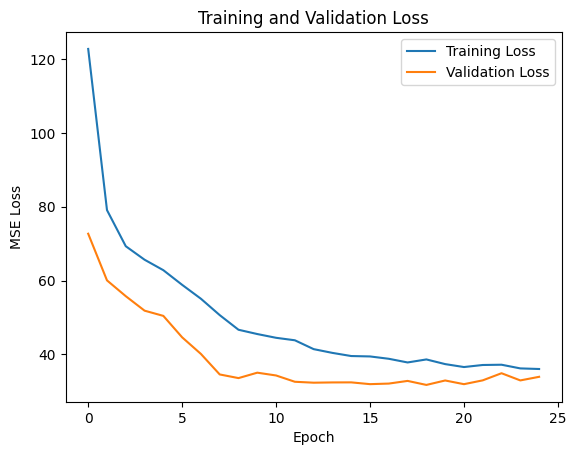

In [34]:
import matplotlib.pyplot as plt


plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()


In [39]:
#Base model:

base = TabTransformer(
    categories = tuple(df[CATEGORICAL_FEATURES].nunique().values) ,      # tuple containing the number of unique values within each category
    num_continuous = len(NUMERICAL_FEATURES),                # number of continuous values
    dim = embed_dim,                           # dimension, paper set at 32
    dim_out = 1,                        # binary prediction, but could be anything
    depth = 6,                          # depth, paper recommended 6
    heads = num_heads,                          # heads, paper recommends 8
    attn_dropout = dropout,                 # post-attention dropout
    ff_dropout = dropout,                   # feed forward dropout
    mlp_hidden_mults = mlp_hidden_units,          # relative multiples of each hidden dimension of the last mlp to logits
    mlp_act = nn.ReLU(),                # activation for final mlp, defaults to relu, but could be anything else (selu etc)
    #continuous_mean_std = cont_mean_std # (optional) - normalize the continuous values before layer norm
)

loaded = TabTransformer(
    categories = tuple(df[CATEGORICAL_FEATURES].nunique().values) ,      # tuple containing the number of unique values within each category
    num_continuous = len(NUMERICAL_FEATURES),                # number of continuous values
    dim = embed_dim,                           # dimension, paper set at 32
    dim_out = 1,                        # binary prediction, but could be anything
    depth = 6,                          # depth, paper recommended 6
    heads = num_heads,                          # heads, paper recommends 8
    attn_dropout = dropout,                 # post-attention dropout
    ff_dropout = dropout,                   # feed forward dropout
    mlp_hidden_mults = mlp_hidden_units,          # relative multiples of each hidden dimension of the last mlp to logits
    mlp_act = nn.ReLU(),                # activation for final mlp, defaults to relu, but could be anything else (selu etc)
    #continuous_mean_std = cont_mean_std # (optional) - normalize the continuous values before layer norm
)

loaded.load_state_dict(torch.load('best_model.pth'))

dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)



base_loss = 0
loaded__loss = 0
new_loss = 0

criterion = nn.MSELoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
base.to(device)
loaded.to(device)
trained_model.to(device)

with torch.no_grad():

  for num, cat, lab in dataloader:

      num, cat, lab = num.to(device), cat.to(device), lab.to(device)
      bs = base(cat, num)
      ld = loaded(cat, num)
      tr = trained_model(cat, num)

      bs = bs.squeeze()
      ld = ld.squeeze()
      tr = tr.squeeze()

      loss = criterion(bs, lab)
      loss2 = criterion(ld, lab)
      loss3 = criterion(tr, lab)

      base_loss += loss.item()
      loaded__loss += loss2.item()
      new_loss += loss3.item()

<ipython-input-39-eae829aeaaf8>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded.load_state_dict(torch.load('best_model.pth'))


In [40]:
base_loss/len(dataloader)

306.30918884277344

In [41]:
loaded__loss/len(dataloader)

44.07911682128906

In [42]:
new_loss/len(dataloader)

44.90401840209961

In [46]:

true_RT = []
predicted_RT = []

batch_1 = DataLoader(test_dataset, batch_size=1, shuffle=False)

with torch.no_grad():

  for num, cat, lab in batch_1:

      num, cat, lab = num.to(device), cat.to(device), lab.to(device)
      predicted = loaded(cat,num)
      true_RT.append(lab.item())
      predicted_RT.append(predicted.item())

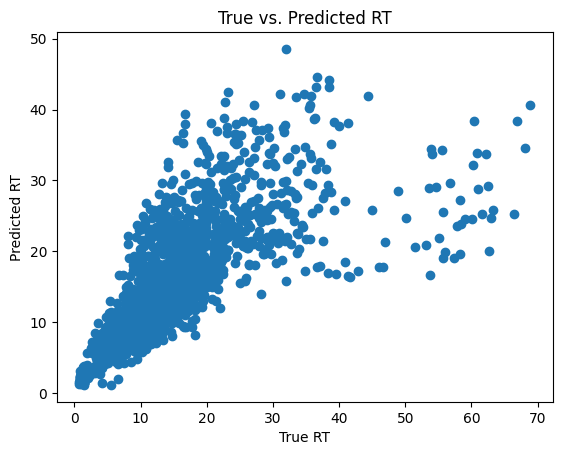

In [50]:
plt.scatter(true_RT, predicted_RT)
plt.xlabel('True RT')
plt.ylabel('Predicted RT')
plt.title('True vs. Predicted RT')
plt.show()

In [53]:
for i in range(50):
  print(true_RT[i])
  print(predicted_RT[i])
  print(">>>>><<<<<")

5.989999771118164
10.080946922302246
>>>>><<<<<
12.329999923706055
7.480006694793701
>>>>><<<<<
5.449999809265137
5.162938117980957
>>>>><<<<<
15.699999809265137
20.511003494262695
>>>>><<<<<
12.979999542236328
20.975242614746094
>>>>><<<<<
6.889999866485596
8.57131576538086
>>>>><<<<<
7.119999885559082
7.231681823730469
>>>>><<<<<
10.65999984741211
11.580757141113281
>>>>><<<<<
12.960000038146973
15.60739517211914
>>>>><<<<<
4.380000114440918
5.168010711669922
>>>>><<<<<
16.489999771118164
9.426961898803711
>>>>><<<<<
58.290000915527344
27.178091049194336
>>>>><<<<<
7.309999942779541
9.175348281860352
>>>>><<<<<
12.850000381469727
10.540444374084473
>>>>><<<<<
10.930000305175781
10.301233291625977
>>>>><<<<<
11.350000381469727
8.705743789672852
>>>>><<<<<
16.770000457763672
18.058374404907227
>>>>><<<<<
20.899999618530273
22.417348861694336
>>>>><<<<<
40.939998626708984
18.499753952026367
>>>>><<<<<
19.56999969482422
20.651840209960938
>>>>><<<<<
18.6200008392334
17.222898483276367
>>